In [ ]:
!pip install kaggle
from google.colab import files

files.upload()

KeyboardInterrupt: 

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d dataset

In [ ]:
import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
class_to_idx = {
    'Melanocytic Nevi': 0,
    'Melanoma': 1,
    'Vascular lesions': 2,
    'Benign keratosis-like lesions ': 3,  # Make sure the label matches exactly (including spaces)
    'Basal cell carcinoma': 4,
    'Actinic keratoses': 5,
    'Dermatofibroma': 6
}


In [ ]:
path = '/content/dataset/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}
# Reading Metadata csv file
skin_df = pd.read_csv('/content/dataset/HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = skin_df['cell_type'].map(class_to_idx)

In [ ]:
from tqdm import tqdm
import cv2
from PIL import Image

In [ ]:
# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

# n_samples = 5
# fig, m_axs = plt.subplots(7, n_samples, figsize=(3 * n_samples, 3 * 7))
# for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['cell_type']).groupby('cell_type')):
#     n_axs[0].set_title(type_name)  # Sesuaikan ukuran font di sini
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
#         c_ax.imshow(c_row['image'])
#         c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=600)


In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign keratosis-like lesions,3
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign keratosis-like lesions,3
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign keratosis-like lesions,3
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign keratosis-like lesions,3
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/dataset/HAM10000_images_part_2/ISIC_0...,Benign keratosis-like lesions,3


In [ ]:
skin_df["cell_type_idx"].unique()

array([3, 0, 6, 1, 2, 4, 5])

In [ ]:
import seaborn as sns

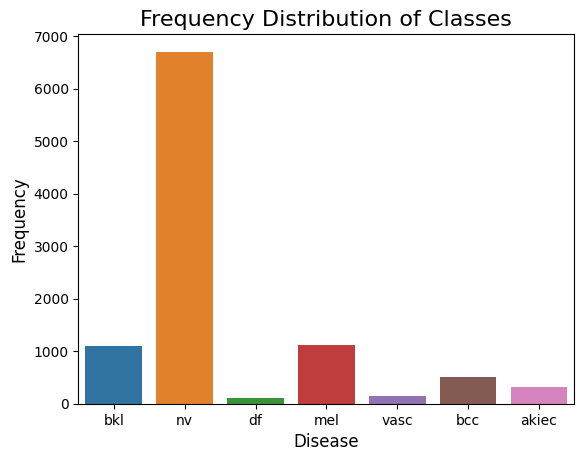

In [ ]:
sns.countplot(x = 'dx', data = skin_df)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

## Settings and Dataset

In [ ]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 20
BATCH_SIZE = 128
IMG_SIZE = 125

# Architecture
NUM_CLASSES = 10

# Preparing Dataset

In [ ]:
dataset_df = skin_df[['path', 'cell_type_idx']].copy()

In [ ]:
print(dataset_df.head())

                                                path  cell_type_idx
0  /content/dataset/HAM10000_images_part_1/ISIC_0...              3
1  /content/dataset/HAM10000_images_part_1/ISIC_0...              3
2  /content/dataset/HAM10000_images_part_1/ISIC_0...              3
3  /content/dataset/HAM10000_images_part_1/ISIC_0...              3
4  /content/dataset/HAM10000_images_part_2/ISIC_0...              3


In [ ]:
# Menyimpan DataFrame ke dalam file CSV
dataset_df.to_csv('dataset.csv', index=False)

In [ ]:
from torch.utils.data import Dataset
from skimage import io
import cv2 as cv

class takeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]
        image = io.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform is not None:  # Pastikan transformasi dapat dipanggil
            image = self.transform(image)

        return (image, y_label)

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((125, 125)), transforms.ToTensor()])

dataset = takeDataset(csv_file='dataset.csv', transform = transform)

train_set, temp_set = torch.utils.data.random_split(dataset, [7000, len(dataset) - 7000])
valid_set, test_set = torch.utils.data.random_split(temp_set, [1500, len(temp_set) - 1500])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np

# # Define the data augmentation parameters
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     rescale=1./255  # Normalize pixel values to [0, 1]
# )

# # Apply data augmentation to the train_loader
# augmented_images = []
# augmented_labels = []

# for images, labels in train_loader:
#     # Convert PyTorch tensor to NumPy array
#     images_np = np.moveaxis(images.numpy(), 1, 3)

#     # Store original images and labels
#     augmented_images.extend(images_np)
#     augmented_labels.extend(labels.numpy())

#     # Apply data augmentation
#     augmented_batch = datagen.flow(images_np, labels, batch_size=len(images), shuffle=False)
#     augmented_images.extend(augmented_batch[0][0])
#     augmented_labels.extend(augmented_batch[0][1])

# # Convert the lists to PyTorch tensors
# augmented_images = torch.tensor(augmented_images)
# augmented_labels = torch.tensor(augmented_labels)

In [ ]:
# # Optionally visualize some augmented images
# for i in range(5):  # Visualize the first 5 images
#     index = np.random.randint(len(augmented_images))  # Randomly select an augmented image
#     augmented_image = np.swapaxes(augmented_images[index], 0, 2)  # Swap axes back to (H, W, C)

#     # Display the augmented image along with its label
#     plt.imshow(augmented_image.squeeze(), cmap='gray')
#     plt.title(f"Augmented Image {i+1}, Label: {augmented_labels[index].item()}")
#     plt.show()


In [ ]:
# # Jumlah data sebelum augmentasi
# total_data_before_augmentation = len(train_loader.dataset)

# # Jumlah data setelah augmentasi
# total_data_after_augmentation = len(augmented_images)

# print(f"Total data sebelum augmentasi: {total_data_before_augmentation}")
# print(f"Total data setelah augmentasi: {total_data_after_augmentation}")

In [ ]:
# for augmented_data in augmented_images:
#     images = augmented_data  # Assuming the structure is [images, labels]
#     print('Image batch dimensions:', images.shape)
#     break


In [ ]:
# Ambil batch pertama dari DataLoader
for images, labels in train_loader:
    batch_images = images
    batch_labels = labels
    break

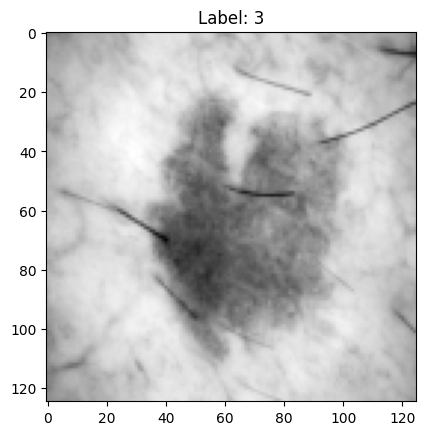

In [ ]:
# Set a fixed seed for reproducibility
torch.manual_seed(42)

image, label = next(iter(train_loader))

# Select one image from the batch (e.g., the first image)
single_image = image[0].squeeze().numpy()  # Squeeze removes the channel dimension for grayscale images

# Display the image
plt.imshow(single_image, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title(f"Label: {label[0].item()}")
plt.show()

# Model

In [ ]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))

    # N = img_size^2
    # construct 2D coordinate array (shape N x 2) and normalize
    # in range [0, 1]
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')

    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()

    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1)  # nodes degree (N,)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

    return A_hat

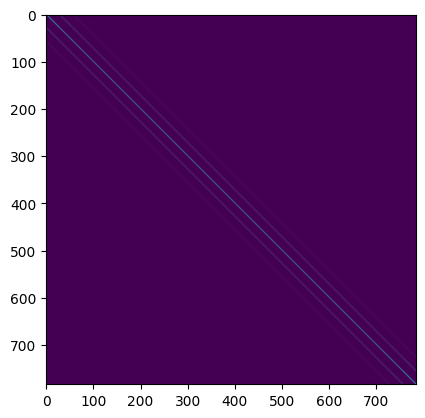

In [ ]:
plt.imshow(precompute_adjacency_matrix(28));

In [ ]:
##########################
### MODEL
##########################

class GraphNet(nn.Module):
    def __init__(self, img_size=56, num_classes=10):
        super(GraphNet, self).__init__()

        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        self.register_buffer('A', A)

    def forward(self, x):

        B = x.size(0) # Batch size

        ### Reshape Adjacency Matrix
        # [N, N] Adj. matrix -> [1, N, N] Adj tensor where N = HxW
        A_tensor = self.A.unsqueeze(0)
        # [1, N, N] Adj tensor -> [B, N, N] tensor
        A_tensor = self.A.expand(B, -1, -1)

        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)

        # bmm = batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))

        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Training

In [ ]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |'
                   f' Cost: {cost:.4f}')



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference

        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)

        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')

        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/055 | Cost: 2.3427
Epoch: 001/020
Train ACC: 60.54 | Validation ACC: 59.27
Time elapsed: 2.58 min
Epoch: 002/020 | Batch 000/055 | Cost: 45.2836
Epoch: 002/020
Train ACC: 65.67 | Validation ACC: 64.22
Time elapsed: 5.07 min
Epoch: 003/020 | Batch 000/055 | Cost: 46.3994
Epoch: 003/020
Train ACC: 65.49 | Validation ACC: 64.16
Time elapsed: 7.58 min
Epoch: 004/020 | Batch 000/055 | Cost: 56.2614
Epoch: 004/020
Train ACC: 20.19 | Validation ACC: 21.52
Time elapsed: 10.08 min
Epoch: 005/020 | Batch 000/055 | Cost: 33.5704
Epoch: 005/020
Train ACC: 66.76 | Validation ACC: 65.48
Time elapsed: 12.59 min
Epoch: 006/020 | Batch 000/055 | Cost: 15.7342
Epoch: 006/020
Train ACC: 26.94 | Validation ACC: 28.51
Time elapsed: 15.08 min
Epoch: 007/020 | Batch 000/055 | Cost: 32.2999
Epoch: 007/020
Train ACC: 66.83 | Validation ACC: 65.94
Time elapsed: 17.58 min
Epoch: 008/020 | Batch 000/055 | Cost: 42.9988
Epoch: 008/020
Train ACC: 66.83 | Validation ACC: 65.94
Time elapsed

# Evaluation

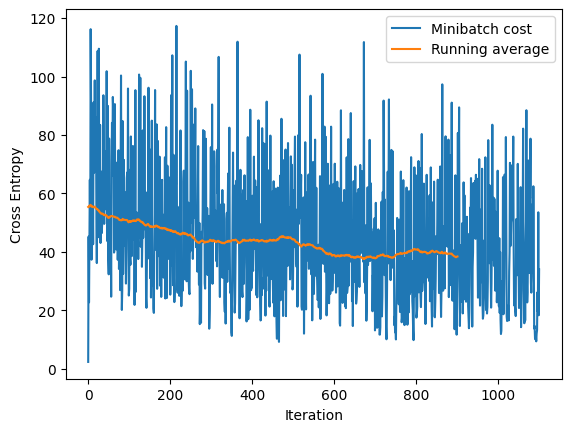

In [ ]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list,
                     np.ones(200,)/200, mode='valid'),
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

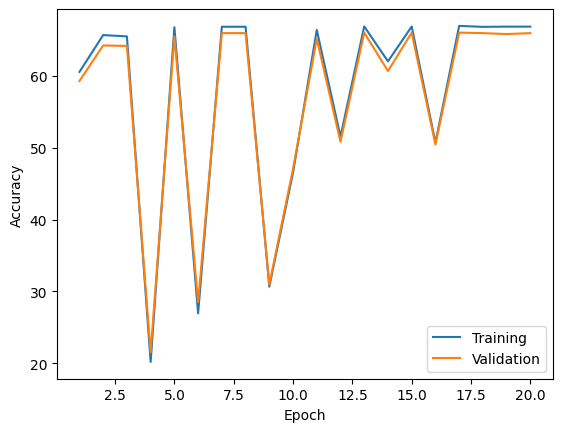

In [ ]:
# Assuming train_acc_list and valid_acc_list contain accuracy values as CUDA tensors
# Move the tensors to the CPU before plotting
train_acc_list_cpu = [acc_item.cpu().numpy() for acc_item in train_acc_list]
valid_acc_list_cpu = [acc_item.cpu().numpy() for acc_item in valid_acc_list]

plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_cpu, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_cpu, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
class_names = ['Melanocytic Nevi', 'Melanoma', 'Benign keratosis-like lesions', 'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma']

In [ ]:
# with torch.set_grad_enabled(False):
#     test_acc = compute_acc(model=model,
#                            data_loader=test_loader,
#                            device=DEVICE)

#     valid_acc = compute_acc(model=model,
#                             data_loader=valid_loader,
#                             device=DEVICE)


# print(f'Validation ACC: {valid_acc:.2f}%')
# print(f'Test ACC: {test_acc:.2f}%')

with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)

    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)

    # Additional evaluation metrics
    y_true, y_pred = [], []

    for features, targets in test_loader:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        _, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

# Classification report
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", classification_rep)

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Classification Report:
                                precision    recall  f1-score   support

             Melanocytic Nevi       0.66      1.00      0.80       999
                     Melanoma       0.00      0.00      0.00       181
Benign keratosis-like lesions       0.00      0.00      0.00        18
         Basal cell carcinoma       0.00      0.00      0.00       164
            Actinic keratoses       0.00      0.00      0.00        91
             Vascular lesions       0.00      0.00      0.00        47
               Dermatofibroma       0.00      0.00      0.00        15

                     accuracy                           0.66      1515
                    macro avg       0.09      0.14      0.11      1515
                 weighted avg       0.44      0.66      0.52      1515

Validation ACC: 65.94%
Test ACC: 65.94%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
